# Statistik-Projekt HS25 – Notebook 05: Wahrscheinlichkeit
## Ziel
Wir untersuchen die Wahrscheinlichkeitsstruktur der Verspätungen.
* Wie wahrscheinlich ist es, dass ein Zug mehr als 3 Minuten Verspätung hat?
* Folgen die Verspätungen einer bekannten statistischen Verteilung (z.B. Normalverteilung, Exponentialverteilung)?

## Methoden
1.  **Empirische Wahrscheinlichkeiten:** Zählen und berechnen von Anteilen.
2.  **QQ-Plot:** Visueller Vergleich mit der Normalverteilung.
3.  **Distribution Fitting:** Anpassen einer Exponentialverteilung an die positiven Verspätungen.

## Input
* Datei: `../data/processed/istdata_clean_extended.parquet`

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path

# 1. Konfiguration
INPUT_PATH = "../../data/processed/istdata_clean_extended.parquet"
FIG_PATH = "../reports/figures"

# 2. Daten laden
print(f"Lade Daten aus {INPUT_PATH}...")
df = pl.read_parquet(INPUT_PATH)

# Sample für Plots und Fits (100k reichen)
df_sample = df.sample(n=100000, seed=42).to_pandas()
print(f"Stichprobe erstellt: {len(df_sample)} Zeilen.")

Lade Daten aus ../../data/processed/istdata_clean_extended.parquet...
Stichprobe erstellt: 100000 Zeilen.


In [2]:
# Grenzwert für Verspätung (in Minuten)
threshold = 3.0

# Berechnung für alle Züge
total_count = len(df)
late_count = df.filter(pl.col("arr_delay_min") >= threshold).height
prob_total = late_count / total_count

print(f"--- Wahrscheinlichkeiten für Verspätung >= {threshold} Min ---")
print(f"Alle Züge: {prob_total:.2%} (oder 1 in {int(1/prob_total)} Zügen)")

# Berechnung pro Linientyp (Fernverkehr vs. S-Bahn)
# Wir gruppieren und berechnen den Anteil
probs_type = (
    df.group_by("linientyp")
    .agg([
        pl.len().alias("total"),
        (pl.col("arr_delay_min") >= threshold).sum().alias("late_count")
    ])
    .with_columns(
        (pl.col("late_count") / pl.col("total")).alias("probability")
    )
    .sort("probability", descending=True)
    .to_pandas()
)

print("\nNach Zugtyp:")
display(probs_type.style.format({"probability": "{:.2%}"}))

--- Wahrscheinlichkeiten für Verspätung >= 3.0 Min ---
Alle Züge: 7.07% (oder 1 in 14 Zügen)

Nach Zugtyp:


,linientyp,total,late_count,probability
0,Andere,82284,11020,13.39%
1,Regional,1104395,100637,9.11%
2,Fernverkehr,294607,25925,8.80%
3,S-Bahn,2720310,159361,5.86%


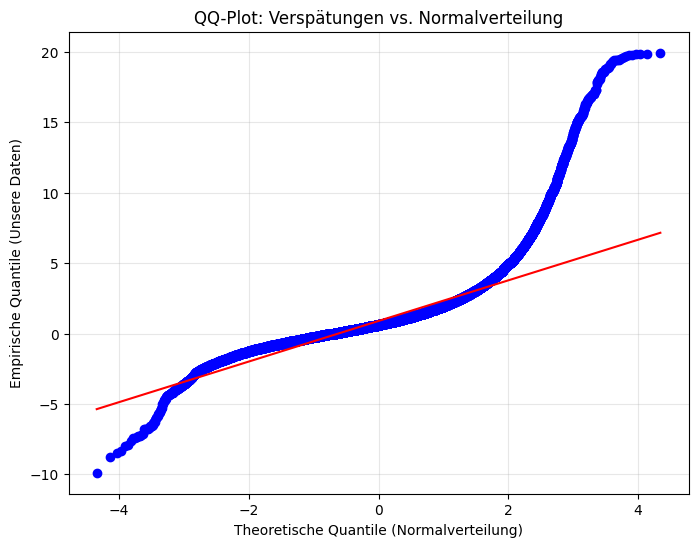

Interpretation: Wenn die Punkte auf der roten Linie liegen, sind die Daten normalverteilt.
Die 'Bananenform' (Abweichung an den Rändern) zeigt: Wir haben 'Heavy Tails' (mehr extreme Verspätungen als bei einer Normalverteilung).


In [3]:
plt.figure(figsize=(8, 6))

# Wir nutzen Scipy für den QQ-Plot
# Wir nehmen nur die Verspätungen zwischen -10 und 20 Min, um extreme Ausreißer im Plot zu vermeiden
data_qq = df_sample[(df_sample["arr_delay_min"] > -10) & (df_sample["arr_delay_min"] < 20)]["arr_delay_min"]

stats.probplot(data_qq, dist="norm", plot=plt)

plt.title("QQ-Plot: Verspätungen vs. Normalverteilung")
plt.xlabel("Theoretische Quantile (Normalverteilung)")
plt.ylabel("Empirische Quantile (Unsere Daten)")
plt.grid(True, alpha=0.3)

plt.savefig(f"{FIG_PATH}/qq_plot_normal.png")
plt.show()

print("Interpretation: Wenn die Punkte auf der roten Linie liegen, sind die Daten normalverteilt.")
print("Die 'Bananenform' (Abweichung an den Rändern) zeigt: Wir haben 'Heavy Tails' (mehr extreme Verspätungen als bei einer Normalverteilung).")

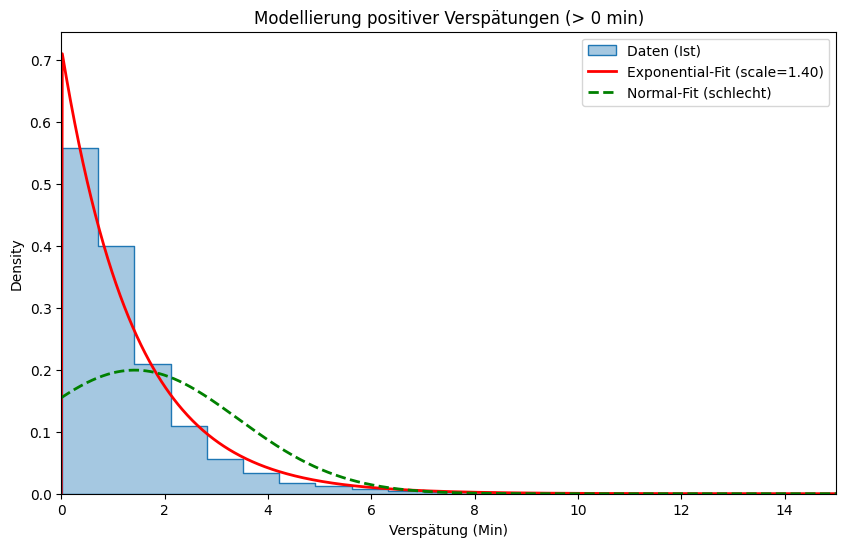

Exponential-Parameter (Lambda = 1/Scale): 0.7120
Die Exponentialverteilung passt oft besser zu Wartezeiten/Ausfällen als die Normalverteilung.


In [4]:
# Wir betrachten nur 'echte' Verspätungen > 0 Minuten
delays_positive = df_sample[df_sample["arr_delay_min"] > 0]["arr_delay_min"]

plt.figure(figsize=(10, 6))

# 1. Histogramm der Daten
sns.histplot(delays_positive, bins=100, stat="density", label="Daten (Ist)", alpha=0.4, element="step")

# 2. Fit Exponentialverteilung
loc_exp, scale_exp = stats.expon.fit(delays_positive)
x = np.linspace(0, 20, 1000)
pdf_exp = stats.expon.pdf(x, loc=loc_exp, scale=scale_exp)
plt.plot(x, pdf_exp, 'r-', lw=2, label=f'Exponential-Fit (scale={scale_exp:.2f})')

# 3. Fit Normalverteilung (zum Vergleich - wird schlecht sein)
loc_norm, scale_norm = stats.norm.fit(delays_positive)
pdf_norm = stats.norm.pdf(x, loc=loc_norm, scale=scale_norm)
plt.plot(x, pdf_norm, 'g--', lw=2, label='Normal-Fit (schlecht)')

plt.xlim(0, 15)
plt.title("Modellierung positiver Verspätungen (> 0 min)")
plt.xlabel("Verspätung (Min)")
plt.legend()

plt.savefig(f"{FIG_PATH}/distribution_fit.png")
plt.show()

print(f"Exponential-Parameter (Lambda = 1/Scale): {1/scale_exp:.4f}")
print("Die Exponentialverteilung passt oft besser zu Wartezeiten/Ausfällen als die Normalverteilung.")